# Salary Predictions Based on Job Descriptions

# Contents


# Part 1 - Problem Definition

### 1. Defining the problem

Estimate job salaries for future comparison on whether salaries are reasonable based on: the job title, company, degree, major, industry, years of experience and distance from a metropolis (miles), as provided by the given dataset. 

In [1]:
#Author
__author__ = "Bennett Heung"
__email__ = "bennett.heung@gmail.com"
__website__ = "https://github.com/Bennett-Heung"

#### Import Libraries

In [189]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.utils import shuffle

%matplotlib inline

#conda install -c conda-forge tabulate

#### Functions

##### Load Data

In [3]:
#Load files into a Pandas dataframe
def load_file(df): 
    return pd.read_csv(df)

#### Data Cleaning

In [4]:
#Missing data check
def n_missing(df):
    return print(df.isnull().sum())

#Check for duplicates
def n_duplicates(df):
    return print(df.duplicated().sum())

#Count no. of matching identifiers between dataframes
def n_identifiers(identifier_col_df1, identifier_col_df2):
    return print(identifier_col_df1.isin(identifier_col_df2).sum())

In [5]:
#Clean text
def df_clean(col, df):
    df[col] = df[col].str.replace('_',' ')
    df[col] = df[col].str.title()

In [6]:
#Check irregular unique categories in each categorical column
    #Define 'feature_categorical_cols' prior to running
def unique_categories(feature_categorical_cols, df):
    for i in feature_categorical_cols:
        print(i, set(df[feature_categorical_cols][i]))

In [7]:
#Summary stats tables:
    # 1) Define and return 'categorical_stats' for category columns
    # 2) Define and return 'numeric_stats' for numeric columns
    # 3) 'df' is the dataframe input

def col_type_split(df): 
    #Categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    categorical_stats = df.describe(include=['object'])
    
    #Numerical columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    numeric_stats = df.describe()
    
    #Outliers IQR * 1.5 rule
    IQR = numeric_stats.loc['75%'] - numeric_stats.loc['25%']
    lower_outliers = pd.Series(numeric_stats.loc['25%'] - 1.5 * IQR)
    upper_outliers = pd.Series(numeric_stats.loc['75%'] + 1.5 * IQR)    
    
    #Outliers check: True = outliers to check, False = no outliers to check
    lower_outlier_check = lower_outliers > numeric_stats.loc['min']
    upper_outlier_check = upper_outliers < numeric_stats.loc['max']
    
    #Add results onto the summary stats table of numeric columns
    outliers_check = pd.concat([lower_outlier_check, lower_outliers, upper_outlier_check, upper_outliers], axis=1)
    outliers_check.columns = ['lower_outlier_check', 'lower_outliers', 'upper_outlier_check', 'upper_outliers']
    outliers_check = outliers_check.transpose()
    
    numeric_stats = pd.concat([numeric_stats, outliers_check])    
    # 1) category columns summary; 2) numeric columns summary
    return categorical_stats, numeric_stats

In [8]:
#Display suspected lower bound outliers
def lower_outliers(numeric_stats, df):
    for i in numeric_stats.columns: 
        lower_outliers = df[df[i] <= numeric_stats[i].loc['lower_outliers']]
        if len(lower_outliers) > 0:
            print('Column: ', i, '\n No. of suspected lower outliers: ', lower_outliers.shape[0])
            display(lower_outliers)
            check_lower_outliers.append(i)
        else: print(i, 'has no suspected lower bound outliers')


#Display suspected uppwer bound outliers
def upper_outliers(numeric_stats, df):
    for i in numeric_stats.columns: 
        upper_outliers = df[df[i] >= numeric_stats[i].loc['upper_outliers']]
        if len(upper_outliers) > 0:
            print('Column: ', i, '\n No. of suspected upper outliers: ', upper_outliers.shape[0])
            display(upper_outliers)
            check_upper_outliers.append(i)
        else: print(i, 'has no suspected upper bound outliers')


#Plot Lower Outliers as per categorical variable
def lower_outliers_count(col_i, col_j, df):   
    lower_outliers = df[df[col_i] <= numeric_stats[col_i].loc['lower_outliers']]
    plt.plot(lower_outliers[col_j].value_counts(),'g')
    plt.xticks(rotation = 90)
    plt.show()


#Plot Upper Outliers as per categorical variable
def upper_outliers_count(col_i, col_j, df):   
    upper_outliers = df[df[col_i] >= numeric_stats[col_i].loc['upper_outliers']]
    plt.plot(upper_outliers[col_j].value_counts(),'b')
    plt.xticks(rotation = 90)
    plt.show()

##### Exploratory Data Analysis (EDA)

In [9]:
#Numeric target variable plots
def numeric_target_plots(target_col_name, df):
    fig = plt.figure()
    plt.figure(figsize=(10, 5))
    
    #1. Boxplot
    plt.subplot(1,2,1)
    sns.boxplot(df[target_col_name])
    
    #2. Distplot
    plt.subplot(1,2,2)
    sns.distplot(df[target_col_name])
    
    plt.savefig('numeric_target_plots.png')
    plt.show()

In [10]:
#Numeric feature variable plots
    #'col' is the numeric feature column name
    #'target_col' is the numeric target column name 
    #'df' is the dataframe that contains both columns
    
def numeric_feature_plots(col, target_col, df):
    fig = plt.figure()
    plt.figure(figsize=(10, 5))

    #Line chart: target vs. variable
    plt.subplot(1,3,1)
    y_mean = df.groupby([col]).mean()
    y_mean = y_mean[target_col]
    y_std = df.groupby([col]).std()
    y_std = y_std[target_col]
    x = y_mean.index
    plt.plot(x, y_mean, '-b')
    plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2)
    plt.xlabel(col)
    plt.ylabel(target_col)

    #Boxplot
    plt.subplot(1,3,2)
    sns.boxplot(df[col])
    
    #Distplot 
    plt.subplot(1,3,3)
    sns.distplot(df[col])
    
    plt.tight_layout()
    plt.savefig('numeric_feature_plots'+str(col)+'.png')
    plt.show()

In [11]:
#Categorical feature variable plots
    #'col' is the categorical feature column name
    #'target_col' is the numeric target column name 
    #'df' is the dataframe that contains both columns
    
def categorical_feature_plots(col, target_col, df):
    fig = plt.figure()
    plt.figure(figsize=(10, 5))

    #bar charts by category
    plt.subplot(1,2,1)
    df[col].value_counts().plot(kind = 'bar')
    plt.xticks(rotation=90)
    
    #boxplots of categories in descending order by mean
    plt.subplot(1,2,2)
    x = df.groupby(by=[col]).mean()
    x_index = x[target_col].sort_values(ascending=False).index
    sns.boxplot(x=df[col], y=df[target_col], order = x_index)
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.savefig('categorical_feature_plots'+str(col)+'.png')
    plt.show()

##### Modelling

In [12]:
#One Hot Encoding 
    #Replaces categorical variables with One Hot Encoding variables into the same dataframe, 'df'
def one_hot_encoding(feature_categorical_cols, df):
    #Create One Hot Encoding dataframe
    categorical_df = df[feature_categorical_cols]
    categorical_df = pd.get_dummies(categorical_df)    
    #Drop categorical variables from the dataframe
    df.drop(df[feature_categorical_cols],axis=1,inplace=True)
    #Concat One Hot Encoding dataframe to the dataframe
    df = pd.concat([df, categorical_df],axis=1)
    return df

## Discover

### Load Data
The features and salary datasets are loaded. 

In [136]:
#Load data and define dataframes
train_features = load_file("train_features.csv")
train_salaries = load_file("train_salaries.csv")
test_features = load_file("test_features.csv")

### Data Cleaning
Data cleaning involved checking and treating for:
- Data types and size of the datasets 
- Missing data
- Duplicates 
- Invalid data
- Suspected outliers. 

In [14]:
#View top five rows
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [15]:
#View top five rows
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [16]:
#View top five rows
test_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [17]:
#Data types and shape
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [18]:
#Data types and shape
train_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [19]:
#Data types and shape
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


Findings: 
- All dataframes contain appropriate object and int64 types
- Column types valid for further analysis.

In [20]:
# Missing data check
n_missing(train_features)

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64


In [21]:
# Missing data check
n_missing(train_salaries)

jobId     0
salary    0
dtype: int64


In [22]:
# Missing data check
n_missing(test_features)

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64


Findings: 
- No missing data detected.

#### Check duplicates

In [23]:
#Count duplicates in 'train_features'
n_duplicates(train_features)

0


In [24]:
#Count duplicates in 'train_salaries'
n_duplicates(train_salaries)

0


In [25]:
#Count duplicates in 'test_features'
n_duplicates(test_features)

0


In [26]:
#Count duplicates between dataframes 
n_identifiers(train_features['jobId'], train_salaries['jobId'])

1000000


In [27]:
#Count duplicates between dataframes 
n_identifiers(train_features['jobId'], test_features['jobId'])

0


In [28]:
#Count duplicates between dataframes 
n_identifiers(train_salaries['jobId'], test_features['jobId'])

0


Findings: 
- No duplicates found within each dataframe
- 'jobId' are unique identifiers for both dataframes
- Individuals across 'train_features' and 'train_salaries' are identical - appropriate to merge for further anaylsis. 
- None of these individuals appear in 'test_salaries'. 

In [29]:
#Define 'train_data' as merged dataframe 
train_data = train_features.merge(train_salaries,left_on='jobId', right_on='jobId', how='inner')
print(train_data.shape)
train_data.head()

(1000000, 9)


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [30]:
#Identify 'train_data' columns
train_data.select_dtypes(include=object).columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry'], dtype='object')

In [31]:
#Clean text for 'jobType' 
train_data['jobType'] = train_data['jobType'].apply(lambda x: x if len(x) <= 3 else x.replace('_', ' ').title())

#Clean text for other categorical columns
clean_cols = ['degree','major','industry']
for cols in clean_cols:
    df_clean(cols, train_data)

In [32]:
#View top five rows
train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,Masters,Math,Health,10,83,130
1,JOB1362684407688,COMP19,CEO,High School,None,Web,3,73,101
2,JOB1362684407689,COMP52,Vice President,Doctoral,Physics,Health,10,38,137
3,JOB1362684407690,COMP38,Manager,Doctoral,Chemistry,Auto,8,17,142
4,JOB1362684407691,COMP7,Vice President,Bachelors,Physics,Finance,8,16,163


In [33]:
#Data types and shape
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


#### Check invalid data

##### Categorical data

In [34]:
#Define categorical columns
categorical_cols = train_data.select_dtypes(include=[object]).columns

#Define unique identifier column from 'categorical_cols'
unique_id = categorical_cols[0]
print('Unique ID column:', unique_id)

#Define columns of categorical features
feature_categorical_cols = categorical_cols[1:].tolist()
print('Feature categorical variables: ', feature_categorical_cols)

Unique ID column: jobId
Feature categorical variables:  ['companyId', 'jobType', 'degree', 'major', 'industry']


In [35]:
#Check irregular unique categories in categorical columns
unique_categories(feature_categorical_cols, train_data)

companyId {'COMP62', 'COMP38', 'COMP57', 'COMP14', 'COMP46', 'COMP2', 'COMP32', 'COMP36', 'COMP45', 'COMP48', 'COMP61', 'COMP60', 'COMP49', 'COMP21', 'COMP44', 'COMP22', 'COMP30', 'COMP42', 'COMP55', 'COMP3', 'COMP5', 'COMP25', 'COMP33', 'COMP58', 'COMP6', 'COMP17', 'COMP15', 'COMP27', 'COMP47', 'COMP56', 'COMP24', 'COMP35', 'COMP1', 'COMP34', 'COMP26', 'COMP39', 'COMP7', 'COMP31', 'COMP53', 'COMP28', 'COMP10', 'COMP59', 'COMP23', 'COMP16', 'COMP11', 'COMP18', 'COMP40', 'COMP52', 'COMP51', 'COMP8', 'COMP4', 'COMP43', 'COMP29', 'COMP12', 'COMP19', 'COMP54', 'COMP50', 'COMP9', 'COMP13', 'COMP41', 'COMP0', 'COMP20', 'COMP37'}
jobType {'Manager', 'Vice President', 'Junior', 'Senior', 'CEO', 'CFO', 'CTO', 'Janitor'}
degree {'High School', 'Masters', 'None', 'Doctoral', 'Bachelors'}
major {'Literature', 'Chemistry', 'Business', 'Physics', 'Biology', 'Compsci', 'None', 'Engineering', 'Math'}
industry {'Web', 'Education', 'Oil', 'Service', 'Finance', 'Auto', 'Health'}


Findings:
- No invalid categories were found. 

In [36]:
#Summary statistics for both categorical and numerical columns:
    #Define 'categorical_stats' as summary statistics for categoircal columns (top)  
    #Define 'numeric_stats' as summary statistics for numerical columns (bottom)  

categorical_stats, numeric_stats = col_type_split(train_data)

In [37]:
#Summary statistics table for categorical columns
display(categorical_stats)

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684926711,COMP39,Senior,High School,None,Web
freq,1,16193,125886,236976,532355,143206


##### Numeric data

In [38]:
#Summary statistics table for numeric columns
display(numeric_stats)

,yearsExperience,milesFromMetropolis,salary
count,1e+06,1e+06,1e+06
mean,11.9924,49.5293,116.062
std,7.21239,28.8777,38.7179
min,0,0,0
25%,6,25,88
50%,12,50,114
75%,18,75,141
max,24,99,301
lower_outlier_check,False,False,True
lower_outliers,-12,-50,8.5


Findings: 
- 'jobId' is the unique indentifier
- No invalid numerical values found: values were all greater than or equal to zero
- Suspected lower and upper bound outliers in 'salary'.

#### Inspect outliers

Suspected lower and upper outliers only in 'salary', as shown by the True values in the 'lower_outlier_check' and 'upper_outlier_check' rows in 'numeric_stats' (above)

In [39]:
#Define lists to indicate suspected lower and upper outliers
check_lower_outliers = []
check_upper_outliers = []

In [40]:
#View suspected lower bound outliers
lower_outliers(numeric_stats, train_data)

yearsExperience has no suspected lower bound outliers
milesFromMetropolis has no suspected lower bound outliers
Column:  salary 
 No. of suspected lower outliers:  5


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,Junior,Doctoral,Math,Auto,11,7,0
495984,JOB1362684903671,COMP34,Junior,None,None,Oil,1,25,0
652076,JOB1362685059763,COMP25,CTO,High School,None,Auto,6,60,0
816129,JOB1362685223816,COMP42,Manager,Doctoral,Engineering,Finance,18,6,0
828156,JOB1362685235843,COMP40,Vice President,Masters,Engineering,Web,3,29,0


In [41]:
#View suspected upper bound outliers
upper_outliers(numeric_stats, train_data)

yearsExperience has no suspected upper bound outliers
milesFromMetropolis has no suspected upper bound outliers
Column:  salary 
 No. of suspected upper outliers:  7117


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,JOB1362684407953,COMP30,CEO,Masters,Biology,Oil,23,60,223
362,JOB1362684408049,COMP38,CTO,Masters,None,Health,24,3,223
560,JOB1362684408247,COMP53,CEO,Masters,Biology,Web,22,7,248
670,JOB1362684408357,COMP26,CEO,Masters,Math,Auto,23,9,240
719,JOB1362684408406,COMP54,Vice President,Doctoral,Biology,Oil,21,14,225
...,...,...,...,...,...,...,...,...,...
998516,JOB1362685406203,COMP29,CFO,Masters,Engineering,Web,14,46,227
999249,JOB1362685406936,COMP30,CEO,None,None,Oil,17,10,223
999280,JOB1362685406967,COMP2,CFO,Bachelors,Business,Service,21,0,228
999670,JOB1362685407357,COMP20,CEO,Doctoral,Literature,Service,24,14,233


Findings:
- only 5 from 1 million individuals potentially missing salary inputs - can drop the small number of individuals 
- 7,117 suspected upper outliers require further exploration - 7,117 of 1 million individuals is not signifcantly large.

In [42]:
#Confirm columns to inspect suspected outliers
print('Columns to inspect for suspected lower outliers: ', check_lower_outliers)
print('Columns to inspect for suspected upper outliers: ', check_upper_outliers)

Columns to inspect for suspected lower outliers:  ['salary']
Columns to inspect for suspected upper outliers:  ['salary']


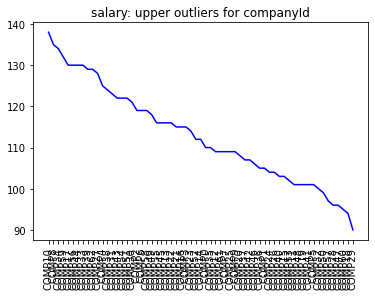

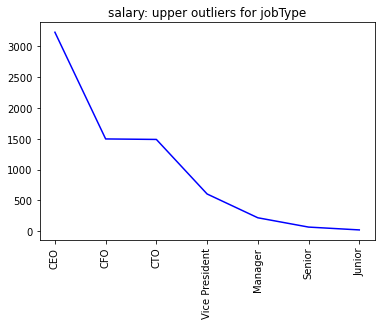

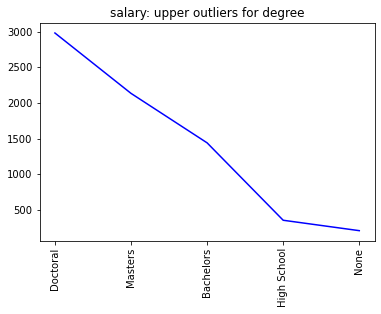

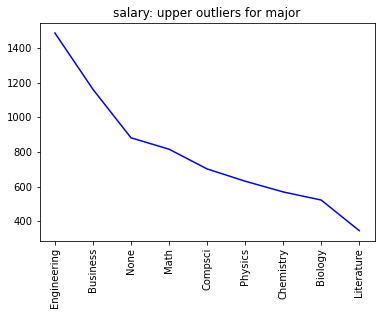

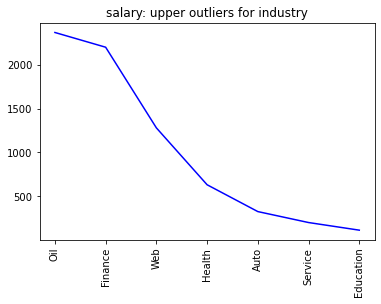

In [197]:
#Plots to explore upper outliers as per category
for i in check_upper_outliers: 
    for j in feature_categorical_cols:
        plt.title(i+': upper outliers for '+j)   
        upper_outliers_count(i,j,train_data)
        filename = str('upper outliers for: ' +j)
        plt.savefig('upper_outliers_'+j+'_'+i+'.png')
        plt.close()

Findings:
- Lower-bound outliers: 
    - Not helpful to predict 'salary'
    - Potentially missing inputs and were treated as 0
    - Dropping 5 observations in 1m observations in data would not make significant impact.

- Upper-bound outliers: 
    - Not much out of 1 million individuals (7,117 indivduals)
    - Tend to be higher-up positions and degrees 
    - Tend to major in Engineering and Business
    - Most likely in the Oil and Finance industries 
    - Outliers make sense - no further actions needed to treat these outliers. 

In [44]:
#Drop lower-bound outliers (salary < 8.5)
train_data = train_data[train_data['salary'] > 8.5]
print(train_data.shape)
train_data.sort_values('salary').head()

(999995, 9)


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
141942,JOB1362684549629,COMP27,Janitor,None,None,Education,0,98,17
188931,JOB1362684596618,COMP26,Janitor,High School,None,Education,1,96,18
807108,JOB1362685214795,COMP29,Janitor,High School,None,Education,0,92,18
482429,JOB1362684890116,COMP46,Janitor,None,None,Education,0,92,18
798142,JOB1362685205829,COMP38,Janitor,None,None,Education,0,75,19


### Exploratory Data Analysis (EDA)
EDA was performed differently between salary (target variable) and the feature numeric and categorical variables. The analysis involves a deeper and visual understanding of the different categories, distributions and relationships each variable has with salary, as well as the distribution of salary itself. In addition, a correlation heatmap is included to indicate correlations between each variable after converting the categorical variables into numeric variables of the average salaries for each category. 

In [45]:
#View data types
train_data.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

#### Definitions
- Numeric variables:
    - Target variable ('salary')
    - Numeric features ('yearsExperience', 'milesFromMetropolis')
- Categorical variables:
    - Unique identifier ('jobId')
    - Categorical features ('companyId','jobType','degree','major','industry')

In [46]:
#Define numeric columns
numeric_cols = train_data.select_dtypes(include=['number']).columns

#Define numeric target column
target_col = numeric_cols[-1]
print('Target variable: ', target_col)

#Define numeric feature columns
feature_numeric_cols = numeric_cols[:-1].tolist()
print('Numeric feature variables: ', feature_numeric_cols)

Target variable:  salary
Numeric feature variables:  ['yearsExperience', 'milesFromMetropolis']


In [47]:
#Categorical columns (from section above)
print('All categorical columns: ', categorical_cols)

#Print results from splitting categorical columns as: unique IDs and categorical feature variables 
print('Unique ID: ', unique_id)
print('Categorical feature variables: ', feature_categorical_cols)

All categorical columns:  Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry'], dtype='object')
Unique ID:  jobId
Categorical feature variables:  ['companyId', 'jobType', 'degree', 'major', 'industry']


#### Numeric Data EDA

<Figure size 432x288 with 0 Axes>

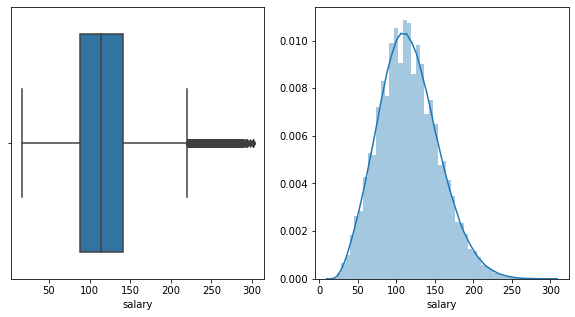

In [48]:
#Numeric target variable ('salary') plots
numeric_target_plots('salary', train_data)

Findings: 
- Salary appears mostly as a normal distribution but slightly skewed right.

<Figure size 432x288 with 0 Axes>

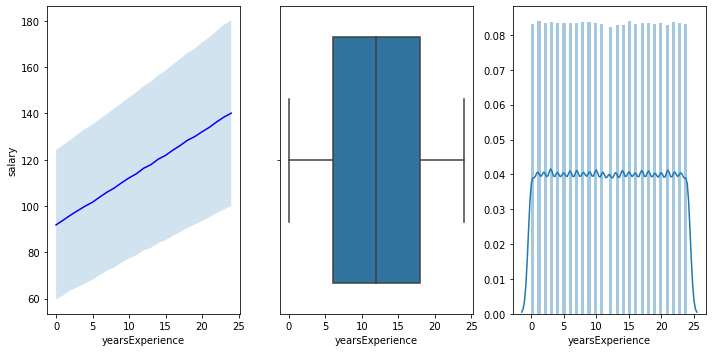

<Figure size 432x288 with 0 Axes>

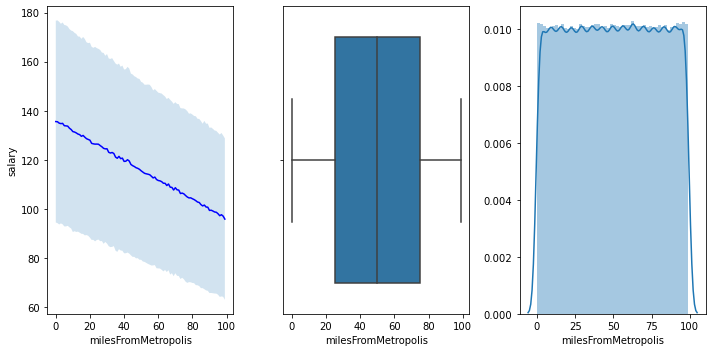

In [49]:
#Numeric feature variable plots
for col in feature_numeric_cols:
    numeric_feature_plots(col, 'salary', train_data)

Findings: 
- CompanyId does not show correlation with salary
- Years of experience has a positive linear correlation with salary
- Miles from Metropolis has a negative linear correlation with salary.

#### Categorical Data

<Figure size 432x288 with 0 Axes>

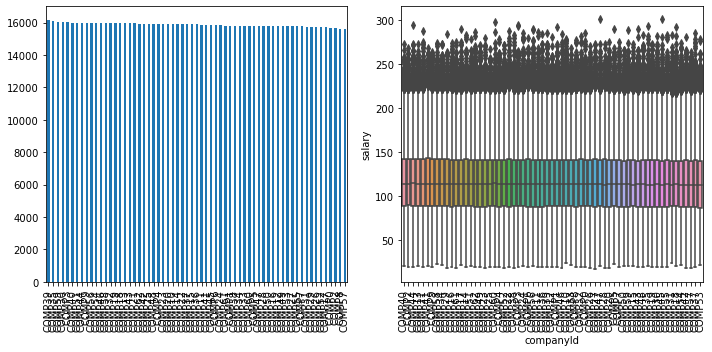

<Figure size 432x288 with 0 Axes>

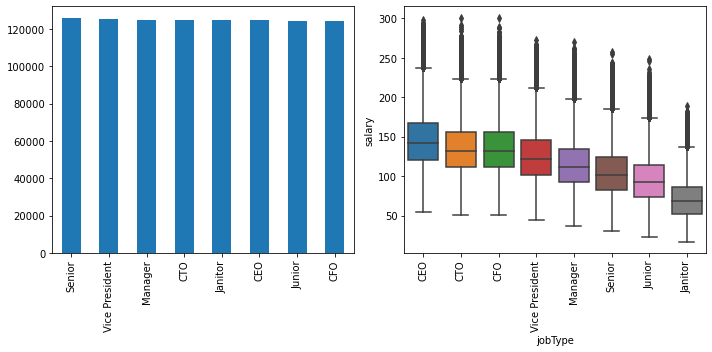

<Figure size 432x288 with 0 Axes>

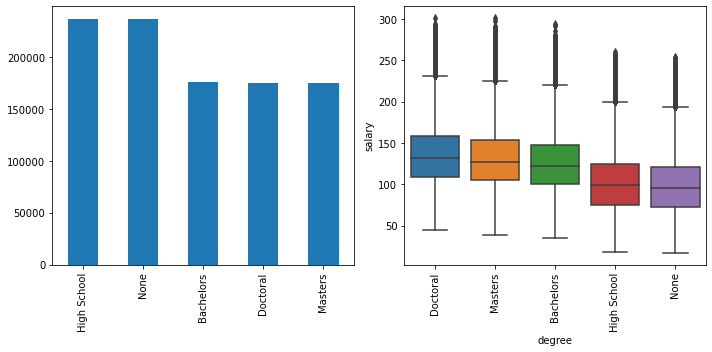

<Figure size 432x288 with 0 Axes>

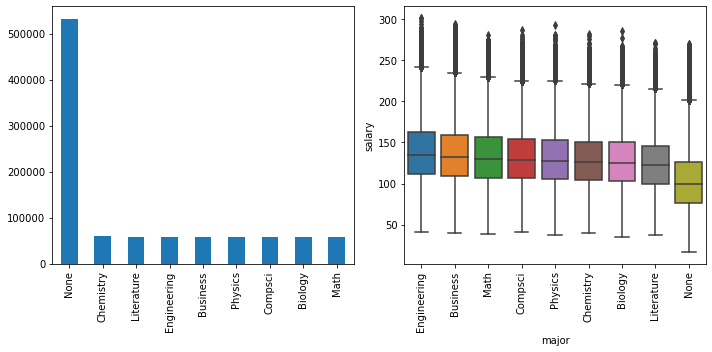

<Figure size 432x288 with 0 Axes>

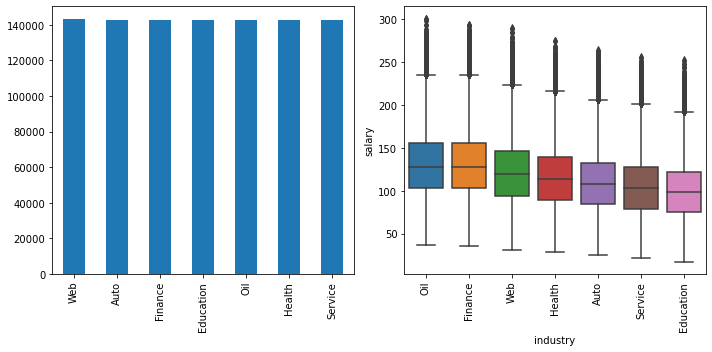

In [50]:
for col in feature_categorical_cols:
    categorical_feature_plots(col, 'salary', train_data)

Findings: 
- Companies show no collinearity with salary
- Higher positions tend to have higher salary
- Higher degrees tend to have higher salary
- While most individuals do not have a major, engineering and business are the majors that are likely to have higher salary
- Oil and finance industries tend to have higher salary than other industries. 

#### Correlations - heatmap

The average salary as per category within each category variable, i.e. object types within the train_data (exc. jobId), were applied in the following heatmap containing correlations across each variable within the dataset. The following steps involved were to: 1) Create copy of train_data; and 2) Convert (and replace) object each column into each categories' average salaries. For example, in the jobType column, CEOs now share value of the CEO's average salaries instead of 'CEO'. 

In [51]:
#Feature categorical variables (defined previously)
feature_categorical_cols

['companyId', 'jobType', 'degree', 'major', 'industry']

In [52]:
#Create copy of train_data
train_data_copy = train_data.copy()

In [53]:
#Convert and replace category values into each categories' average salaries for each categorical variable
for i in feature_categorical_cols: 
    train_data_copy[i] = train_data.groupby(by=i)['salary'].transform('mean')

In [54]:
#View top five rows
train_data_copy.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,115.345049,135.458547,130.505647,133.322042,115.735540,10,83,130
1,JOB1362684407688,115.756548,145.311425,101.921085,102.583864,121.645362,3,73,101
2,JOB1362684407689,116.224249,125.368630,135.490979,130.372436,115.735540,10,38,137
3,JOB1362684407690,116.199380,115.368518,135.490979,129.072085,109.435222,8,17,142
4,JOB1362684407691,115.888501,125.368630,125.454663,130.372436,130.747659,8,16,163


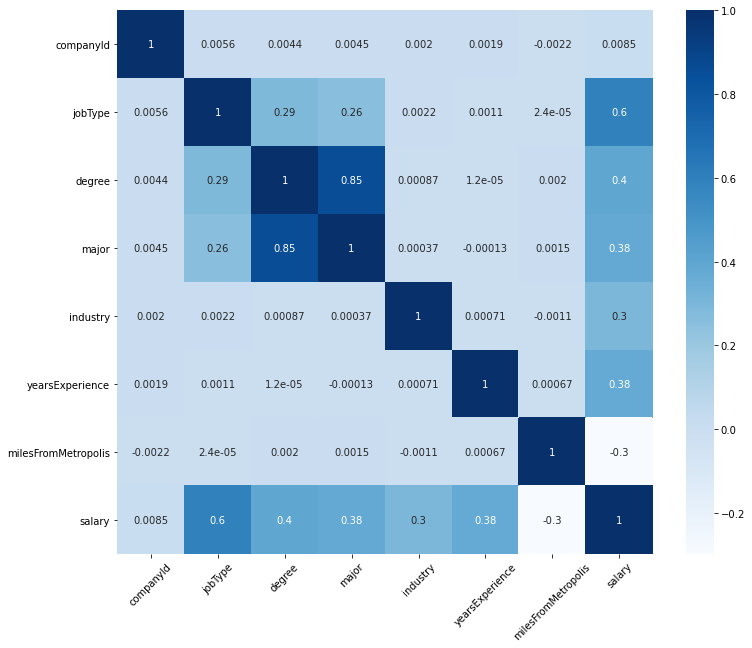

In [55]:
#Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(train_data_copy.corr(),cmap='Blues',annot=True)
plt.xticks(rotation=45)
plt.savefig('corr_heatmap.png')
plt.show()

Findings:
- Variable correlations with salary:
    - There is no significant correlation between companies (companyId) and salary. 
    - Job position (jobType) is the variable that positively correlates most to salary, followed by degree (degree), years of experience (yearsExperience) and major (major). 
    - There is also slight positive correlations between the job industry (industry) and salary. 
    - Only key negative correlation of salary is the miles from metropolis (milesFromMetropolis). 
- Correlations between feature variables: 
    - There is a significant positive correlation between major and degree (0.85).
    - Job positions are slightly positively correlated to both major and degree. 
    - No other collinearity is shown across the feature variables - they are all close to zero.

### Modelling

A baseline model is created first as a benchmark to gauge the mean squared error (MSE). MSE is selected as the model evaluation metric and the modelling below follows a 5-fold cross-validation. 

The following hypothesised solutions are designed to improve the results, i.e. lowering the MSE, with the best solutions tuned further in hopes of improving the models below a targeted MSE. 

#### Baseline

- Create a baseline model and measure MSE as a baseline for evaluating model accuracy.
- The baseline model here is a linear regression that includes the average salaries of each category within each category variable.

In [56]:
#Define baseline target and feature variables
baseline_cols = train_data_copy.columns
baseline_features_cols = baseline_cols[1:-1]
baseline_target_cols = baseline_cols[-1:]

In [57]:
#Import libraries for modelling
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression 
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

In [58]:
#Baseline model
lr = LinearRegression()
baseline_neg_mse = cross_val_score(lr, train_data_copy[baseline_features_cols], 
                                   train_data_copy[baseline_target_cols], cv=5, scoring='neg_mean_squared_error')
baseline_mse_mean = -1*baseline_neg_mse.mean()
baseline_mse_std = baseline_neg_mse.std()

print("Average Baseline MSE Score: ", baseline_mse_mean)
print("Baseline MSE Score Standard Deviation: ", baseline_mse_std)

Average Baseline MSE Score:  399.1237501025735
Baseline MSE Score Standard Deviation:  1.856272658305156


#### Models

The dataframe is updated to improve results: 
- One hot encoding of the categorical feature variables: 'companyId', 'jobType', 'degree', major' and 'industry'
- Normalising the numeric feature variables - 'yearsExperience', 'milesFromMetropolis'.

After normalising and one-hot-encoding the features, the hypothesised solutions (below) were tested and compared with the baseline to improve results (lower MSEs). The objective here is to find the best model that has mean square error below 360.

Regressions: 
- Linear Regression
- Lasso Regression 
- Ridge Regression 

Regression Trees:
- Decision Tree Regressor
- Random Tree Regressor*
- Gradient Boosting Regressor

*Note: n_estimators were applied due to memory errors and not time-efficient to run vanilla

In [59]:
#Define copy of train_data for modelling
train_df = train_data.copy()

#Shuffle to improve cross-validation accuracy and and reindexed
train_df = shuffle(train_df).reset_index(drop=True)
print(train_df.shape)
train_df.head()

(999995, 9)


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684667444,COMP28,CTO,Masters,Math,Web,7,80,143
1,JOB1362684956207,COMP47,Junior,High School,None,Service,14,35,76
2,JOB1362684961041,COMP23,Senior,Bachelors,Biology,Oil,13,24,139
3,JOB1362684885609,COMP41,Senior,None,None,Web,5,74,100
4,JOB1362684687420,COMP57,Junior,Masters,Chemistry,Service,10,11,105


In [60]:
#Define features set and target set for modelling
feature_df = train_df.drop([unique_id, target_col],axis=1)
target_df = train_df[target_col]

In [61]:
#Delete train_df to save space
del train_df

##### One hot encoding categorical features

In [62]:
#View the categorical features
feature_df.columns

Index(['companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')

In [63]:
#One Hot Encoding 
feature_df = one_hot_encoding(feature_categorical_cols, feature_df)

In [64]:
#View top five rows of updated features
feature_df.head()

,yearsExperience,milesFromMetropolis,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,...,major_Math,major_None,major_Physics,industry_Auto,industry_Education,industry_Finance,industry_Health,industry_Oil,industry_Service,industry_Web
0,7,80,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,14,35,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,13,24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,5,74,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,10,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


##### Normalising numeric features

In [65]:
#View the numeric feautures
feature_numeric_cols

['yearsExperience', 'milesFromMetropolis']

In [66]:
#Normalise numeric features to reduce bais based on measurement and range
numeric_df = feature_df[feature_numeric_cols]
numeric_df = MinMaxScaler().fit_transform(numeric_df)
feature_df[feature_numeric_cols] = numeric_df

In [67]:
#View top five rows of updated features
feature_df.head()

,yearsExperience,milesFromMetropolis,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,...,major_Math,major_None,major_Physics,industry_Auto,industry_Education,industry_Finance,industry_Health,industry_Oil,industry_Service,industry_Web
0,0.291667,0.808081,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0.583333,0.353535,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0.541667,0.242424,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.208333,0.747475,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0.416667,0.111111,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


##### Creating and testing the models

In [68]:
#Train and evaluate models using cross_val_score, scored by MSE
def train_eval_model(model, feature_df, target_df, mse_mean, mse_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=5, scoring='neg_mean_squared_error')
    mse_mean[model] = -1*neg_mse.mean()
    mse_std[model] = neg_mse.std()
    print(model, "mse_mean: ", mse_mean[model], "mse_std: ", mse_std[model])

In [69]:
#Vanilla Models
    # Parameters set at default if not specified
    # random_state=0 set as default across all models (exc. linear regression)

#Vanilla Linear Regressions 
lr = LinearRegression()
Lasso = linear_model.Lasso()
Ridge = linear_model.Ridge()

#Vanilla Regression Trees
dtr = tree.DecisionTreeRegressor()
gbm = ensemble.GradientBoostingRegressor()
rfr = ensemble.RandomForestRegressor(n_estimators=10)

In [70]:
#Store model and the mean and standard deviation of MSE results
models = [lr, Lasso, Ridge, dtr, gbm, rfr]
mse_mean = {}
mse_std = {}

In [71]:
#parallel cross-validate models, using MSE as evaluation metric
for model in models:
    train_eval_model(model, feature_df, target_df, mse_mean, mse_std)

LinearRegression() mse_mean:  384.4294565872766 mse_std:  0.7497326524514364
Lasso() mse_mean:  519.3108406142717 mse_std:  0.35048070743295157
Ridge() mse_mean:  384.43151997996085 mse_std:  0.7481727898481261
DecisionTreeRegressor() mse_mean:  700.1958305624861 mse_std:  2.012587578862378
GradientBoostingRegressor() mse_mean:  375.3980115560943 mse_std:  0.9293629493380235
RandomForestRegressor(n_estimators=10) mse_mean:  428.8513948849815 mse_std:  0.6336909627559782


In [72]:
#Vanilla model MSEs - mean and standard deviation
mse_stats_vanilla = pd.DataFrame([mse_mean, mse_std]).T
mse_stats_vanilla.columns = ['mse_mean','mse_std']
mse_stats_vanilla.index = ['Linear Regression',
                           'Lasso Regression', 
                           'Ridge Regression',
                           'Decision Tree Regressor',
                           'Gradient Boosting Regressor', 
                           'Random Forest Regressor']

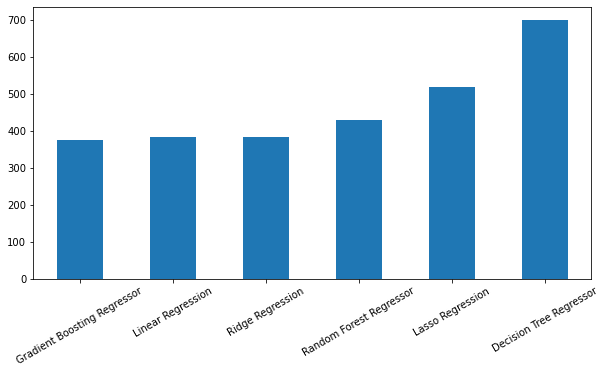

In [124]:
#Plot vanilla models' MSEs
plt.figure(figsize=(10, 5))

#bar charts
mse_stats_sorted= mse_stats_vanilla.sort_values('mse_mean',ascending=True)
mse_stats_sorted['mse_mean'].plot(kind = 'bar')
plt.xticks(rotation=30)
plt.savefig('vanilla_models_mse.png', bbox_inches = 'tight')
plt.show()

<Figure size 432x288 with 0 Axes>

The two selected vanilla models with the lowest MSEs to tune further are the Gradient Boosting Regressor and Ridge regression.

#### Grid Search
Hyperparameters are tested in aim of lowering the MSE to below 360 for both the Ridge regression and the Gradient Boosting Regressor. 

In [74]:
#Grid Search hyperparameters

#Ridge
alpha = [0.01, 0.1, 1, 10]

#Gradient Boosting Regressor
n_estimators = [50, 100, 150, 200]
max_depth = [3,7,9]

In [75]:
#Ridge regression

#Restore for Ridge Regression results
mse_mean = {}
mse_std = {}

#Alphas
for i in alpha:
    Ridge = linear_model.Ridge(alpha=i, random_state=0)
    train_eval_model(Ridge, feature_df, target_df, mse_mean, mse_std)

#DataFrame results 
mse_stats_Ridge = pd.DataFrame([mse_mean, mse_std]).T
mse_stats_Ridge.columns = ['mse_mean','mse_std']
display(mse_stats_Ridge)

#Lowest MSE
lowest_mse_Ridge = mse_stats_Ridge[mse_stats_Ridge['mse_mean']==min(mse_stats_Ridge['mse_mean'])]
print('Ridge Regression with the Lowest MSE')
display(lowest_mse_Ridge)

Ridge(alpha=0.01, random_state=0) mse_mean:  384.43152479965056 mse_std:  0.7481789716661917
Ridge(alpha=0.1, random_state=0) mse_mean:  384.43152435126586 mse_std:  0.748178409689217
Ridge(alpha=1, random_state=0) mse_mean:  384.43151997996085 mse_std:  0.7481727898481261
Ridge(alpha=10, random_state=0) mse_mean:  384.4314875182069 mse_std:  0.7481165842921961


,mse_mean,mse_std
"Ridge(alpha=0.01, random_state=0)",384.431525,0.748179
"Ridge(alpha=0.1, random_state=0)",384.431524,0.748178
"Ridge(alpha=1, random_state=0)",384.431520,0.748173
"Ridge(alpha=10, random_state=0)",384.431488,0.748117


Ridge Regression with the Lowest MSE


,mse_mean,mse_std
"Ridge(alpha=10, random_state=0)",384.431488,0.748117


In [76]:
#Gradient Boosting Regressor 

#Restore for Gradient Boosting Regressor results
mse_mean = {}
mse_std = {}

#max_depth and n_estimators
for m in max_depth:
    for n in n_estimators:
            gbm = ensemble.GradientBoostingRegressor(n_estimators=n, max_depth=m, random_state=0)
            train_eval_model(gbm, feature_df, target_df, mse_mean, mse_std)

#DataFrame results 
mse_stats_gbr = pd.DataFrame([mse_mean, mse_std]).T
mse_stats_gbr.columns = ['mse_mean','mse_std']
display(mse_stats_gbr)

#Lowest MSE
lowest_mse_gbr = mse_stats_gbr[mse_stats_gbr['mse_mean']==min(mse_stats_gbr['mse_mean'])]
print('Gradient Boosting Regressor with the Lowest MSE')
display(lowest_mse_gbr)

GradientBoostingRegressor(n_estimators=50, random_state=0) mse_mean:  440.7048406601865 mse_std:  0.9593944765458885
GradientBoostingRegressor(random_state=0) mse_mean:  375.398011556094 mse_std:  0.9293629493384478
GradientBoostingRegressor(n_estimators=150, random_state=0) mse_mean:  363.2401945215728 mse_std:  0.9165386782079705
GradientBoostingRegressor(n_estimators=200, random_state=0) mse_mean:  359.2194253827314 mse_std:  0.8350952666987987
GradientBoostingRegressor(max_depth=7, n_estimators=50, random_state=0) mse_mean:  365.6015359058821 mse_std:  0.827500010398228
GradientBoostingRegressor(max_depth=7, random_state=0) mse_mean:  357.25834707657384 mse_std:  0.7168256901187292
GradientBoostingRegressor(max_depth=7, n_estimators=150, random_state=0) mse_mean:  356.8985044033745 mse_std:  0.6894178810855223
GradientBoostingRegressor(max_depth=7, n_estimators=200, random_state=0) mse_mean:  357.05414249001876 mse_std:  0.6624834826509278
GradientBoostingRegressor(max_depth=9, n_e

,mse_mean,mse_std
"GradientBoostingRegressor(n_estimators=50, random_state=0)",440.704841,0.959394
GradientBoostingRegressor(random_state=0),375.398012,0.929363
"GradientBoostingRegressor(n_estimators=150, random_state=0)",363.240195,0.916539
"GradientBoostingRegressor(n_estimators=200, random_state=0)",359.219425,0.835095
"GradientBoostingRegressor(max_depth=7, n_estimators=50, random_state=0)",365.601536,0.827500
"GradientBoostingRegressor(max_depth=7, random_state=0)",357.258347,0.716826
"GradientBoostingRegressor(max_depth=7, n_estimators=150, random_state=0)",356.898504,0.689418
"GradientBoostingRegressor(max_depth=7, n_estimators=200, random_state=0)",357.054142,0.662483
"GradientBoostingRegressor(max_depth=9, n_estimators=50, random_state=0)",360.880058,0.901125
"GradientBoostingRegressor(max_depth=9, random_state=0)",357.991386,0.704527


Gradient Boosting Regressor with the Lowest MSE


,mse_mean,mse_std
"GradientBoostingRegressor(n_estimators=50, random_state=0)",440.704841,0.959394
GradientBoostingRegressor(random_state=0),375.398012,0.929363
"GradientBoostingRegressor(n_estimators=150, random_state=0)",363.240195,0.916539
"GradientBoostingRegressor(n_estimators=200, random_state=0)",359.219425,0.835095
"GradientBoostingRegressor(max_depth=7, n_estimators=50, random_state=0)",365.601536,0.827500
"GradientBoostingRegressor(max_depth=7, random_state=0)",357.258347,0.716826
"GradientBoostingRegressor(max_depth=7, n_estimators=150, random_state=0)",356.898504,0.689418
"GradientBoostingRegressor(max_depth=7, n_estimators=200, random_state=0)",357.054142,0.662483
"GradientBoostingRegressor(max_depth=9, n_estimators=50, random_state=0)",360.880058,0.901125
"GradientBoostingRegressor(max_depth=9, random_state=0)",357.991386,0.704527


In [186]:
def markdown_table(df):
    print(df.to_markdown())

Findings

Ridge regressions: 
- Various alphas made insignificant differences to the Ridge regressions. 
- Ridge regression (alpha = 10, random_state = 0) has the smallest MSE.

Gradient Boosting Regressors:
- Gradient Boosting Regressors performed better overall in terms of lower MSEs.
- Gradient Boosting Regressor (max_depth=7, n_estimators=150, random_state=0) has the smallest MSE.

In [153]:
#Concat the Ridge regression and Gradient Boosting Regressor with the lowest MSE 
lowest_mse = pd.concat([lowest_mse_Ridge, lowest_mse_gbr],axis=0)
lowest_mse

mse_mean   mse_std
Ridge(alpha=10, random_state=0)                     384.431488  0.748117
([DecisionTreeRegressor(criterion='friedman_mse...  356.898504  0.689418

In [111]:
#Model with Lowest MSE to train and predict salaries on test set
lowest_mse_ = lowest_mse[lowest_mse['mse_mean']==min(lowest_mse['mse_mean'])]
lowest_mse_.index

Index([([DecisionTreeRegressor(criterion='friedman_mse', max_depth=7,\n                      random_state=RandomState(MT19937) at 0x2CE2585E440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=7,\n                      random_state=RandomState(MT19937) at 0x2CE2585E440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=7,\n                      random_state=RandomState(MT19937) at 0x2CE2585E440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=7,\n                      random_state=RandomState(MT19937) at 0x2CE2585E440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=7,\n                      random_state=RandomState(MT19937) at 0x2CE2585E440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=7,\n                      random_state=RandomState(MT19937) at 0x2CE2585E440)], [DecisionTreeRegressor(criterion='friedman_mse', max_depth=7,\n                      random_state=RandomState(MT19937) at 0x2CE2585E440)], [DecisionTreeRegres

Gradient Boosting Regressor (max_depth=7, n_estimators=150, random_state=0) has the smallest MSE. 
It is the model to train on the entire dataset. 

In [114]:
#Define 'model' as model with the lowest MSE
model = ensemble.GradientBoostingRegressor(max_depth=7, n_estimators=150, random_state=0)
#train model on entire dataset
model.fit(feature_df, target_df)

GradientBoostingRegressor(max_depth=7, n_estimators=150, random_state=0)

#### Feature importance

In [149]:
#feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(feature_df.columns)
    
feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

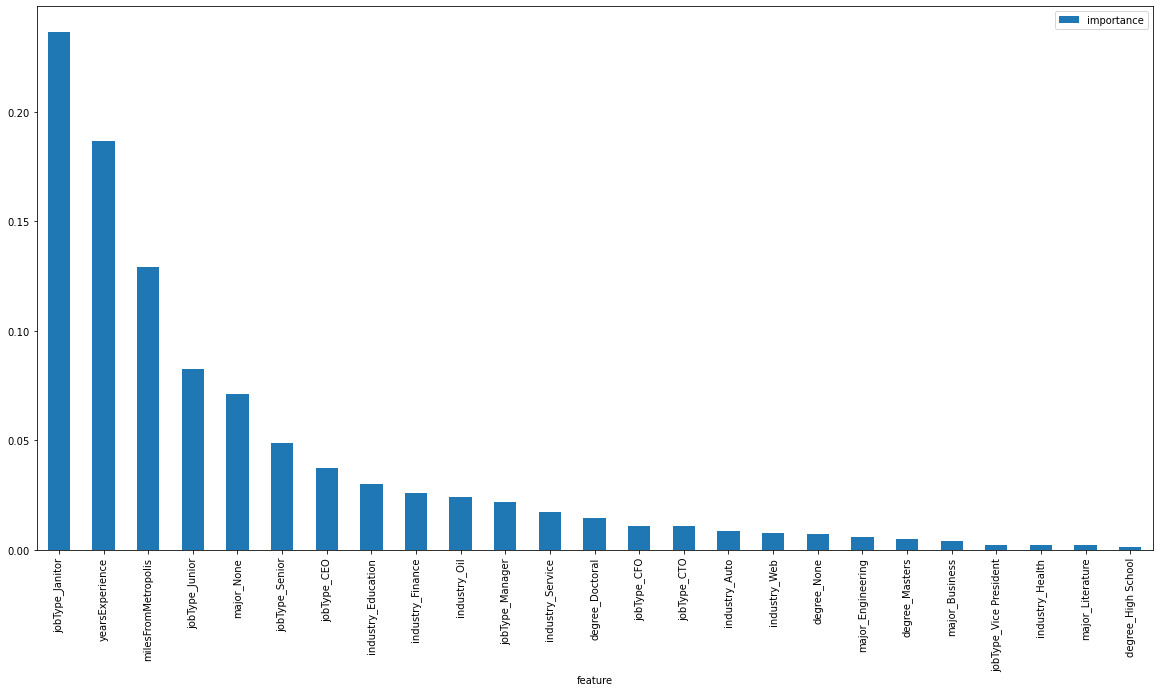

In [154]:
#Plot top 25 feature importances
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.savefig('feature_importances.png',bbox_inches = 'tight')
plt.show()

In [ ]:
#Table of top 10 feature importances 
feature_importances[0:5]

### Deploy solution

In [156]:
#Create copy of test_features
test_features1 = test_features.copy()
#Define unique identifiers of the test set
test_jobId = test_features1['jobId']

In [157]:
#Drop unique identifiers
test_features1 = test_features1.drop('jobId',axis=1)
test_features1

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
...,...,...,...,...,...,...,...
999995,COMP54,VICE_PRESIDENT,BACHELORS,MATH,OIL,14,3
999996,COMP5,MANAGER,NONE,NONE,HEALTH,20,67
999997,COMP61,JANITOR,NONE,NONE,OIL,1,91
999998,COMP19,CTO,DOCTORAL,MATH,OIL,14,63


In [158]:
#One hot encoding on categorical features
test_features1 = one_hot_encoding(feature_categorical_cols, test_features1)

In [160]:
#Normalise numeric features to reduce bais based on measurement and range
numeric_df1 = test_features1[feature_numeric_cols]
numeric_df1 = MinMaxScaler().fit_transform(numeric_df1)
test_features1[feature_numeric_cols] = numeric_df1

In [161]:
#View test_features1
test_features1

,yearsExperience,milesFromMetropolis,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,0.916667,0.737374,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.833333,0.474747,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
2,0.708333,0.090909,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.583333,0.969697,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0.416667,0.444444,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.583333,0.030303,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
999996,0.833333,0.676768,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
999997,0.041667,0.919192,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
999998,0.583333,0.636364,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [163]:
#Model to be deployed  
print(model)

#Salary predictions on test set
test_salaries = model.predict(test_features1)

GradientBoostingRegressor(max_depth=7, n_estimators=150, random_state=0)


In [170]:
test_salaries = pd.DataFrame(test_salaries)

In [171]:
#test_salaries = pd.DataFrame(test_salaries)
test_salaries1 = pd.concat([test_jobId, test_salaries],axis=1)
test_salaries1.head()

,jobId,0
0,JOB1362685407687,112.276684
1,JOB1362685407688,92.116687
2,JOB1362685407689,181.639551
3,JOB1362685407690,104.902131
4,JOB1362685407691,118.095964


In [174]:
#Rename 'salary' column
test_salaries1.columns = ['jobId','salary']
test_salaries1

,jobId,salary
0,JOB1362685407687,112.276684
1,JOB1362685407688,92.116687
2,JOB1362685407689,181.639551
3,JOB1362685407690,104.902131
4,JOB1362685407691,118.095964
...,...,...
999995,JOB1362686407682,166.440146
999996,JOB1362686407683,105.690939
999997,JOB1362686407684,54.941126
999998,JOB1362686407685,160.823383


In [180]:
#Save salary predictions for each jobId to csv 
test_salaries1.to_csv('test_salaries.csv')